# Personal Finance Assistant

Using an Assistants API:
- Get the latest stock prices
- Calculate the gain/loss for each investment and create a chart
- Email a report

## Step 1: Import the required packages

- I will not be using SDKs, mostly using the standard packages
- Using python-dotenv to load the environment variables

In [1]:
import time
import requests
from datetime import datetime
import os
import io
import html

from openai import AzureOpenAI
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile

import yfinance as yf
from PIL import Image
from dotenv import load_dotenv

## Step 2: Read the environment variables

In [2]:
load_dotenv()
api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")
email_URI = os.getenv("EMAIL_URI")

## Step 3: Get an AzureOpenAI client

In [3]:
client = AzureOpenAI(api_key=api_key,
        api_version=api_version,
        azure_endpoint=api_endpoint)

## Step 4: Prepare the functions that the Assistant will call

In [4]:
def get_stock_price(symbol: str) -> float:
    stock = yf.Ticker(symbol)
    price = stock.history(period="1d")['Close'].iloc[-1]
    return price

In [5]:
def send_logic_apps_email(to: str, content: str):
    json_payload = {'to': to, 'content': html.unescape(content)}
    headers = {'Content-Type': 'application/json'}
    response = requests.post(email_URI, json=json_payload, headers=headers)
    if response.status_code == 202:
        print("Email sent to: " + json_payload['to'])

## Step 5: Prepare the Assistant supporting settings

### Step 5.1: Prepare the Tools definition

In [6]:
tools_list = [
{"type": "code_interpreter"},
{"type": "function",
    "function": {

        "name": "get_stock_price",
        "description": "Retrieve the latest closing price of a stock using its ticker symbol.",
        "parameters": {
            "type": "object",
            "properties": {
                "symbol": {
                    "type": "string",
                    "description": "The ticker symbol of the stock"
                }
            },
            "required": ["symbol"]
        }
    }
},
{
    "type": "function",
    "function": {
        "name": "send_email",
        "description": "Sends an email to a recipient(s).",
        "parameters": {
            "type": "object",
            "properties": {
                "to": {
                    "type": "string",
                    "description": "The email(s) the email should be sent to."
                },
                "content": {
                    "type": "string",
                    "description": "The content of the email."
                }
            },
            "required": ["to", "content"]
        }
    }
}]

In [7]:
DATA_FOLDER = "data/finance/"
def upload_file(client, path):
    file = client.files.create(file=open(path, "rb"), purpose="assistants")
    return file

arr = os.listdir(DATA_FOLDER)
assistant_files = []
for file in arr:
    filePath =  DATA_FOLDER + file
    assistant_files.append(upload_file(client, filePath))

file_ids = [file.id for file in assistant_files]
file_ids

['assistant-KFspAGbPYuAvjGAYi1XlgVf8']

## Step 6: Create the Assistant with the settings and the user Thread (the conversation)

In [8]:
assistant = client.beta.assistants.create(
    name="Portfolio Management Assistant",
    instructions="You are a personal securities trading assistant. Please be polite, professional, helpful, and friendly. "+
    "Use the provided portfolio CSV file to answer the questions. If question is not related to the portfolio or you cannot answer the question, say, 'contact a representative for more assistance.'" +
    "If the user asks for help or says 'help', provide a list of sample questions that you can answer.",
    tools=tools_list, 
    model=api_deployment_name,
    file_ids=file_ids
)

thread = client.beta.threads.create()

## Step 7: Call the Assistant Functions

In [9]:
def call_functions(client, thread, run):
    print("Function Calling")
    required_actions = run.required_action.submit_tool_outputs.model_dump()
    print(required_actions)
    tool_outputs = []
    import json
    for action in required_actions["tool_calls"]:
        func_name = action['function']['name']
        arguments = json.loads(action['function']['arguments'])
        
        if func_name == "get_stock_price":
            output = get_stock_price(symbol=arguments['symbol'])
            tool_outputs.append({
                "tool_call_id": action['id'],
                "output": output
            })
        elif func_name == "send_email":
            print("Sending email...")
            email_to = arguments['to']
            email_content = arguments['content']
            send_logic_apps_email(email_to,email_content)
            
            tool_outputs.append({
                "tool_call_id": action['id'],
                "output": "Email sent"
            })
        else:
            raise ValueError(f"Unknown function: {func_name}")
        
    print("Submitting outputs back to the Assistant...")
    client.beta.threads.runs.submit_tool_outputs(
        thread_id=thread.id,
        run_id=run.id,
        tool_outputs=tool_outputs
    )

## Step 7: Function to print the Thread Messages

In [10]:


def format_messages(thread_messages):
    
    message_list = []

    # Get all the messages till the last user message
    for message in thread_messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the messages to show the last user message first
    message_list.reverse()

    # Print the user or Assistant messages or images
    for message in message_list:                
        for item in message.content:
            # Determine the content type
            if isinstance(item, MessageContentText):
                print(f'{message.role}:\n{item.text.value}\n')
                file_annotations = item.text.annotations
                if file_annotations:
                    for annotation in file_annotations:
                        print(f'Annotation: {annotation}')
            elif isinstance(item, MessageContentImageFile):
                # Retrieve image from file id
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                # Convert bytes to image
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                # Resize image to fit in terminal
                width, height = image.size
                image = image.resize((width //2, height //2), Image.LANCZOS)
                # Display image
                image.show()

## Step 8: Function to process the user's Prompt

In [11]:
def process_message(content:str):
    client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=content
    )

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="The current date and time is: " + datetime.now().strftime("%x %X") + "."
    )
    
    print("processing...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
        elif run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            # Handle failed
            break
        elif run.status == "expired":
            # Handle expired
            break
        elif run.status == "cancelled":
            # Handle cancelled
            break
        elif run.status == "requires_action":
            call_functions(client, thread, run)
        else:            
            time.sleep(5)

## Step 9: Have a conversation with the Assistant

In [12]:
process_message("Based on the provided portfolio, what investments do I own?")

processing...
user:
Based on the provided portfolio, what investments do I own?

assistant:
It appears that the portfolio file doesn't contain a column named 'Investment'. Let's check the structure of the provided file to understand its contents better.

assistant:
Your portfolio contains the following investments:

- Microsoft (MSFT): 300 shares, average cost of 200 per share
- Apple (AAPL): 200 shares, average cost of 114 per share
- Amazon (AMZN): 50 shares, average cost of 125 per share
- Tesla (TSLA): 100 shares, average cost of 900 per share
- Netflix (NFLX): 80 shares, average cost of 540 per share

Please note that these are the shares you own, based on the provided portfolio. The average cost is the average price paid per share. The 'Symbol' column contains the ticker symbols for these companies.



In [13]:
process_message("What is the value of my portfolio?")

processing...
Function Calling
{'tool_calls': [{'id': 'call_LiXMa4VcT8nBhVYdjPRGUEqy', 'function': {'arguments': '{\n  "symbol": "MSFT"\n}', 'name': 'get_stock_price'}, 'type': 'function'}]}
Submitting outputs back to the Assistant...
Function Calling
{'tool_calls': [{'id': 'call_RWACoWbs9OUlLLaZFy7aBs6B', 'function': {'arguments': '{\n  "symbol": "AAPL"\n}', 'name': 'get_stock_price'}, 'type': 'function'}]}
Submitting outputs back to the Assistant...
Function Calling
{'tool_calls': [{'id': 'call_lggv6nnJdE2OF7n7Z6Ghlw4j', 'function': {'arguments': '{\n  "symbol": "AMZN"\n}', 'name': 'get_stock_price'}, 'type': 'function'}]}
Submitting outputs back to the Assistant...
Function Calling
{'tool_calls': [{'id': 'call_fF7pGYjmyNwQB4Te7hL2x0Hy', 'function': {'arguments': '{\n  "symbol": "TSLA"\n}', 'name': 'get_stock_price'}, 'type': 'function'}]}
Submitting outputs back to the Assistant...
Function Calling
{'tool_calls': [{'id': 'call_YnTl8Zasl5SEzhbjUdXdkEUo', 'function': {'arguments': '{\

In [14]:
process_message("What is my best and worst investment?")

processing...
user:
What is my best and worst investment?

assistant:
Based on the current prices, 

- Your best investment is in Microsoft (MSFT), with a profit of approximately $64,578. 
- Your worst investment is in Tesla (TSLA), with a loss of approximately $-71,187. 

Please note that the actual profit or loss can only be realized once the stocks are sold. Also, stock values fluctuate, so these positions might change in the future.



processing...
user:
Chart the realized gain or loss of my investments.



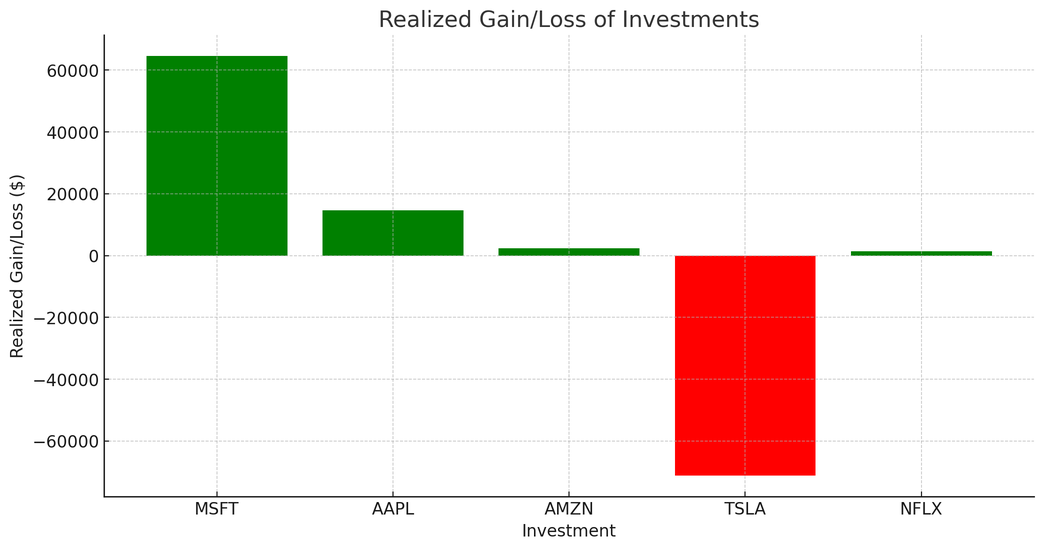

assistant:
Here's a chart depicting the realized gain or loss for your investments:

- The green bars indicate a gain (profit) on the investment.
- The red bars indicate a loss.

As shown, Microsoft (MSFT) has yielded significant gains, while the investment in Tesla (TSLA) has resulted in a substantial loss. The other investments hover around the break-even point, with slight gains or losses. 

These values are based on the current stock prices compared with the average cost paid for each share. Please remember that these are unrealized gains or losses, as you still hold these stocks in your portfolio. The situation may change when you sell these stocks.



In [15]:
process_message("Chart the realized gain or loss of my investments.")

In [16]:
process_message("Please email an HTML formatted report to alemor@microsoft.com with the details for each stock based on the latest stock prices, and list the best and worst performing stocks in my portfolio.")

processing...
Function Calling
{'tool_calls': [{'id': 'call_Ft18FLG01nFRPfI5KHtBde8N', 'function': {'arguments': '{\n  "to": "alemor@microsoft.com",\n  "content": "\\n<p>Dear User,</p>\\n\\n<p>Here are the details for each stock in your portfolio based on the latest stock prices:</p>\\n\\n<table border=\\"1\\" class=\\"dataframe\\">\\n  <thead>\\n    <tr style=\\"text-align: right;\\">\\n      <th></th>\\n      <th>Symbol</th>\\n      <th>Average_Cost</th>\\n      <th>QTY</th>\\n      <th>Current_Value</th>\\n      <th>Profit_Loss</th>\\n    </tr>\\n  </thead>\\n  <tbody>\\n    <tr>\\n      <th>0</th>\\n      <td>MSFT</td>\\n      <td>200</td>\\n      <td>300</td>\\n      <td>124578.0</td>\\n      <td>64578.0</td>\\n    </tr>\\n    <tr>\\n      <th>1</th>\\n      <td>AAPL</td>\\n      <td>114</td>\\n      <td>200</td>\\n      <td>37430.0</td>\\n      <td>14630.0</td>\\n    </tr>\\n    <tr>\\n      <th>2</th>\\n      <td>AMZN</td>\\n      <td>125</td>\\n      <td>50</td>\\n      <td>861

## Step 10: Delete the Assistant, Thread and Files

In [17]:
client.beta.assistants.delete(assistant.id)
client.beta.threads.delete(thread.id)
for file in assistant_files:
    client.files.delete(file.id)